# Прогнозирование оттока клиентов банка

 На основании исторических данных о поведении клиентов и расторжении договоров с банком необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.   

 <b> Цель проекта:</b> построить модель-классификатор, которая определит вероятность того, что отдельно взятый клиент расторгнет договор с банком.

В качестве метрики качества модели мы будем использовать главным образом F1-меру, которая представляет собой баланс метрик precision и recall, а также будем оценивать AUROC моделей. Минимальным значением F1 для нас по условию является 0.59.



Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


## План проекта:  
1. Откроем и изучим файл с данными
2. Подготовим данные к построению моделей
3. Исследуем баланс классов, обучим модели без учёта дисбаланса
4. Улучшим качество моделей, учитывая дисбаланс классов
5. Проведём финальное тестирование с лучшей моделью
6. Сделаем выводы

# Изучение данных

In [6]:
import sys; print(sys.version)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.utils import shuffle

#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.model_selection import GridSearchCV
#from yellowbrick.model_selection import FeatureImportances

from IPython.display import display
import warnings
warnings.simplefilter("ignore")

3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]


In [7]:
clients = pd.read_csv('/datasets/Churn.csv')
display(clients)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [8]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


* Данные имеют подходящие типы во всех столбцах.
* Строковые данные мы позже закодируем в числовой вид.
* Есть пропуски в столбце с данными о наличии недвижимости. Первая мысль: у этих клиентов может не быть недвижимости в собственности. Исследуем это явление позже.

In [9]:
clients.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [10]:
#Проверим данные на наличие дубликатов
clients.duplicated().sum()

0

In [11]:
#Проверим столбец ID клиента на наличие дубликатов, он важен для нас, так как прогноз будет составлять по каждому клиенту
clients['CustomerId'].duplicated().sum()

0

**Вывод**  

На данном этапе мы сделали первый взгляд на данные. Для дальнейшего анализа и построения модели уберем столбцы, которые никак не влияют на отток клинетов и построения модели, такие как номер строки, ID клиента и его имя (CustomerId, Surname, RowNumber). Имеются пропуски в столбце "Количество недвижимости", удалим этот столбец, так в случае удаления пустых строк и удаления всего столбца, результат f1 различался на 0,03 и был лучше во втором случае.

In [12]:
#подготовка таблицы для дальнейшей работы
clients = clients.loc[:, ['CreditScore', 'Geography', 'Gender',
     'Age', 'Tenure', 'Balance', 'NumOfProducts', 
     'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]
display(clients.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


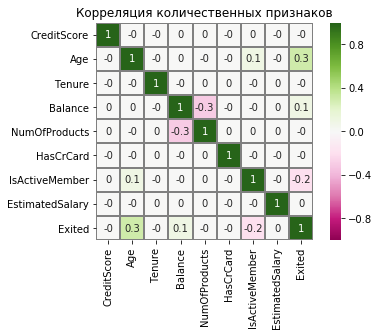

In [13]:
#проверим нет ли мультиколлинеарности между параметрами
sns.heatmap(
    round(clients.corr(), 1),
    annot = True, fmt = '.0g', square = True,
    vmin=-1, vmax=1,
    center= 0,
    linewidths=1,
    linecolor='grey',
    #mask=matrix,
    cmap= 'PiYG'
)
sns.set(rc={'figure.figsize':(7.0,7.0)})
plt.title('Корреляция количественных признаков')
plt.show()

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

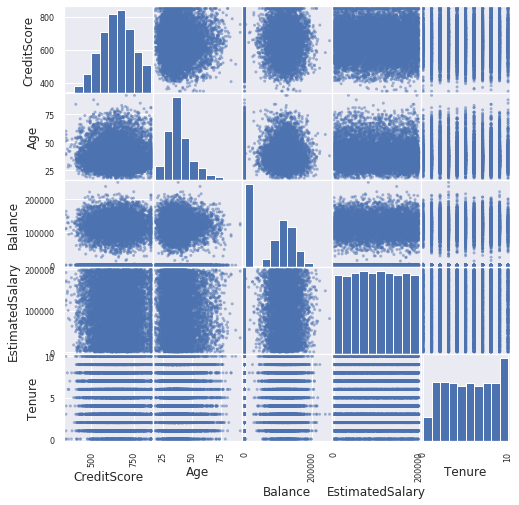

In [14]:
#посмотрим на характер зависимостей признаков 
display(clients.columns)
pd.plotting.scatter_matrix(
    clients.loc[
        :, ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']],
    figsize = (8, 8))
plt.show()

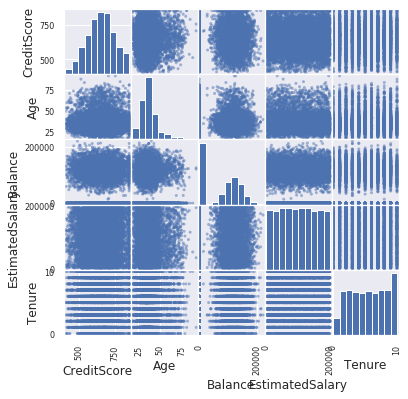

In [15]:
#посмотрим на корреляции для класса "0"
exited_0 = clients[clients['Exited'] == 0]
pd.plotting.scatter_matrix(
    exited_0.loc[
        :, ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']],
    figsize = (6, 6))
plt.show()

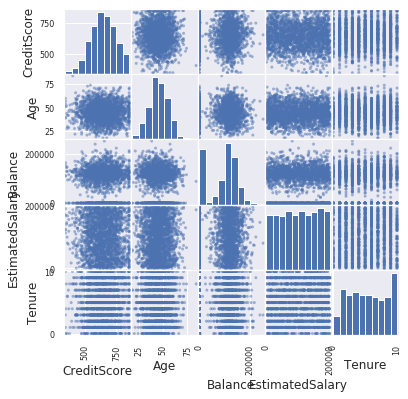

In [16]:
#посмотрим на корреляции для класса "1"
exited_0 = clients[clients['Exited'] == 1]
pd.plotting.scatter_matrix(
    exited_0.loc[
        :, ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']],
    figsize = (6, 6))
plt.show()

**Мультиколлинерованости между параметрами нет, другие столбцы из анализа убирать не будем. Коррелиции между параметрами также не наблюдается**

* Количественные признаки имеют разный масштаб: посмотрим глазами на их распределения.
 Для этого нарисуем гистограммы для каждого количественного столбца.

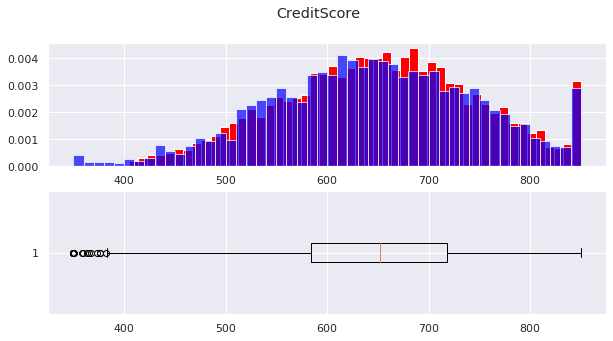

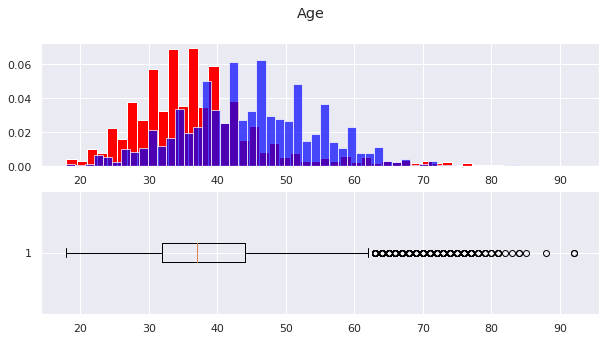

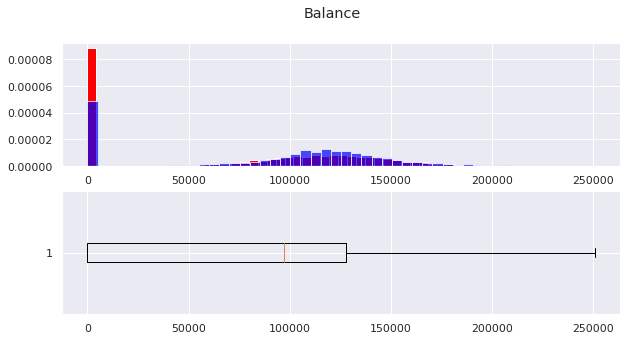

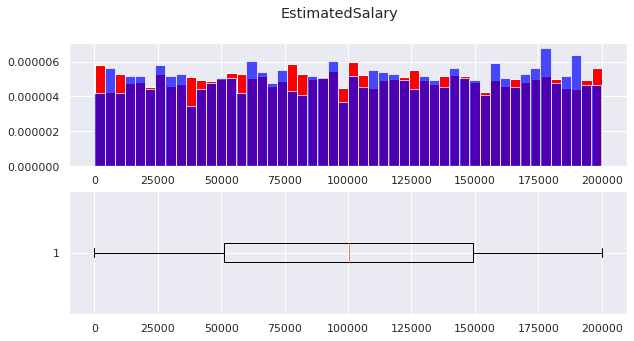

In [17]:
#строим гистограммы и боксплоты для каждого количественного признака
columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for row in columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))
    axes[0].hist(clients.query('Exited == 0')[row], color = 'red', density=True, bins=50, label = 'Класс 0')
    axes[0].hist(clients.query('Exited == 1')[row], color = 'blue', density=True, bins=50, label = 'Класс 1', alpha = 0.7)
    axes[1].boxplot(clients[row], showfliers=True, vert=False)
    plt.suptitle(row)
    plt.show()

**Вывод**  

По гистограмме выявлены некоторые аномалии, например, достаточно большое количество клиентов с максимальным кредитным рейтингом. Выделяются также клиенты у которых на балансе нет денежных средств. При этом распределение клиентов по заработной плате практичеси одинаковое - возможно, что наша выборка из 10000 человек стратифицирована по зарплате..

In [18]:
#посмотрим у каких клиентов наблюдается нулевой баланс с точки зрения оттока
display(clients.query('Balance == 0')['Exited'].value_counts(normalize=True))
display(clients.query('Balance == 0'))

0    0.861764
1    0.138236
Name: Exited, dtype: float64

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1
3,699,France,Female,39,1.0,0.0,2,0,0,93826.63,0
6,822,France,Male,50,7.0,0.0,2,1,1,10062.80,0
11,497,Spain,Male,24,3.0,0.0,2,1,0,76390.01,0
12,476,France,Female,34,10.0,0.0,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...
9989,841,Spain,Male,28,4.0,0.0,2,1,1,179436.60,0
9992,726,Spain,Male,36,2.0,0.0,1,1,0,195192.40,0
9994,800,France,Female,29,2.0,0.0,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.0,2,1,0,96270.64,0


**Обнаружили, что нулевой баланс преобладает у клиентов, которые не ушли из банка. Возможно, это связано с тем, что это новые клиенты**

In [19]:
#посмотрим у каких клиентов наблюдается максимальный кредитный скоринг с точки зрения оттока
display(clients.query('CreditScore == 850')['Exited'].value_counts(normalize=True))
display(clients.query('CreditScore == 850'))

0    0.815451
1    0.184549
Name: Exited, dtype: float64

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
38,850,France,Male,36,7.0,0.00,1,1,1,40812.90,0
180,850,Spain,Female,45,NaN,122311.21,1,1,1,19482.50,0
200,850,Spain,Male,30,2.0,141040.01,1,1,1,5978.20,0
223,850,France,Male,33,10.0,0.00,1,1,0,4861.72,1
...,...,...,...,...,...,...,...,...,...,...,...
9581,850,France,Female,28,9.0,0.00,2,1,1,164864.67,0
9646,850,Spain,Male,71,10.0,69608.14,1,1,0,97893.40,1
9688,850,France,Male,68,5.0,169445.40,1,1,1,186335.07,0
9931,850,France,Female,34,NaN,101266.51,1,1,0,33501.98,0


**Количество клиентос с максимальным кредитным рейтингом составляет лишь 2% от всего числа, что является некритичным для анализа**

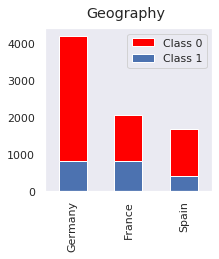

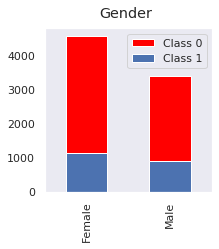

In [20]:
#строим столбчатые диаграммы для качественных признаков
columns = ['Geography', 'Gender']
for row in columns:
    clients.query('Exited == 0')[row].value_counts().plot(y=row, kind='bar', figsize=(3, 3), label = "Class 0", color='red')
    clients.query('Exited == 1')[row].value_counts().plot(y=row, kind='bar', figsize=(3, 3), label = "Class 1")
    plt.legend()
    plt.suptitle(row)
    plt.grid()
    plt.show()

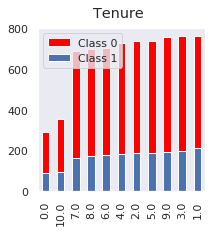

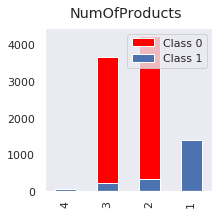

In [21]:
#строим столбчатые диаграммы для количественных признаков
columns = ['Tenure', 'NumOfProducts']
for row in columns:
    clients.query('Exited == 0')[row].value_counts(ascending=True).plot(
        y=row, kind='bar', figsize=(3, 3), label='Class 0', color='red')
    clients.query('Exited == 1')[row].value_counts(ascending=True).plot(
        y=row, kind='bar', figsize=(3, 3), label='Class 1')
    plt.legend()
    plt.suptitle(row)
    plt.grid()
    plt.show()

Интересный факт, что ушедшие клиенты имели в основном один продукт банка

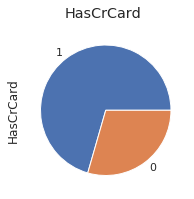

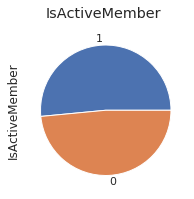

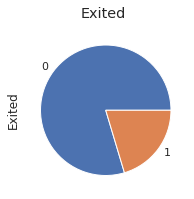

In [22]:
#строим круговые диаграммы для остальных булевых признаков
columns = ['HasCrCard', 'IsActiveMember', 'Exited']
for row in columns:
    clients[row].value_counts(normalize=True).plot(y=row, kind='pie', figsize=(3, 3))
    plt.suptitle(row)
    plt.grid()
    plt.show()

In [23]:
clients['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

## Вывод
* Загрузили файл, изучили информацию. 
* Дубликатов нет, име.тся строки с путыми значения по столбцу количества недвижимости,  заполним его медианным значением, типы данных установлены корректно для дальнейшей работы с ними. 

* Удалили столбцы, которые не повлияют на отток клинетов и лишь усложнят обучение модели (CustomerId, Surname, RowNumber).

* Проверили данные на мультиколлинеарность, определили ее отсутвие.  

* При анализе данных с помощью гистограм, боксплотов, столбчатых и круговых диаграмм выяснили, что представленные нам данные имеют нормальное распределение ('CreditScore', 'Age', 'Balance'), сильных выбросов нет. 

* Выяснили, что существует дисбаланс классов целевого признака Exited (1 - 20%, 0 - 80%).

# Подготовка данных

Для структурированности столбец "Balance" разделим на категории 'low', 'medium', 'high', добавим столбец "zero_balance" - нулевой баланс, так как как мне кажется этот показатель влияет на отток клиентов. Сам столбец balance удалим.

In [24]:
label_ranges = [-1, clients['Balance'].max()/3, clients['Balance'].max()/3*2, np.inf]
label_names = ['low', 'medium', 'high']

#создадим столбец категория баланса
clients['cat_balance'] = pd.cut(clients['Balance'], bins = label_ranges, 
                                labels = label_names)
clients['cat_balance'].value_counts() 

medium    5262
low       4353
high       385
Name: cat_balance, dtype: int64

In [25]:
clients['zero_balance'] = clients['Balance']
clients.loc[clients['Balance'] > 0, 'zero_balance'] = 1
clients['zero_balance'].value_counts()

1.0    6383
0.0    3617
Name: zero_balance, dtype: int64

In [26]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
cat_balance        10000 non-null category
zero_balance       10000 non-null float64
dtypes: category(1), float64(4), int64(6), object(2)
memory usage: 947.5+ KB


In [27]:
clients['Tenure'].fillna(clients['Tenure'].median(), inplace=True)

In [28]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
cat_balance        10000 non-null category
zero_balance       10000 non-null float64
dtypes: category(1), float64(4), int64(6), object(2)
memory usage: 947.5+ KB


In [29]:
clients.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'cat_balance', 'zero_balance'],
      dtype='object')

In [30]:
clients = clients.loc[:, ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance',
       'Exited', 'cat_balance', 'zero_balance']]
#преобразуем категорильные признаки в численные с помощью метода OHE
clients_ohe = pd.get_dummies(clients,  drop_first=True)

#создадим таблицу с признаками и отдельно с целевым признаком
features = clients_ohe.drop(['Exited'], axis=1)
target = clients_ohe['Exited']

In [31]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Balance            10000 non-null float64
Exited             10000 non-null int64
cat_balance        10000 non-null category
zero_balance       10000 non-null float64
dtypes: category(1), float64(4), int64(6), object(2)
memory usage: 947.5+ KB


In [32]:
#рассчитаем значимость каждого признака
model_import = ExtraTreesClassifier(n_estimators=250, random_state = 12345)
model_import.fit(features, target)
importance_data = pd.DataFrame(data = model_import.feature_importances_, index=features.columns, columns=['Importance'])
importance_data = importance_data.sort_values(by='Importance', ascending=False)
display(importance_data)

,Importance
Age,0.224096
NumOfProducts,0.148603
CreditScore,0.134561
EstimatedSalary,0.132599
Tenure,0.104538
Balance,0.103519
IsActiveMember,0.035844
Geography_Germany,0.030138
HasCrCard,0.022606
Gender_Male,0.019556


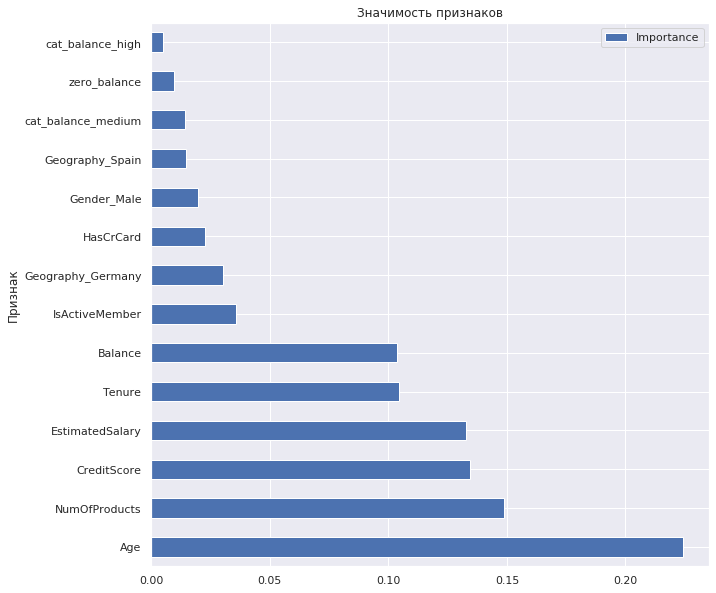

In [33]:
#отразим важность влияния признаков на графике
importance_data.plot(kind='barh', figsize=(10,10))
plt.title('Значимость признаков')
plt.ylabel('Признак')
plt.show()

Признаки геоиспания и гендерное деление являются наименее значимыми, удалим признак "Пол", чтобы не дескридитировать клиентов, неходящихся в Испании.

In [34]:
features = features.drop(['Gender_Male', 'zero_balance', 'cat_balance_high', 'cat_balance_medium'], axis=1)

In [35]:
#разбиваем на обучающую_валидационную и тестовую, тестовой отводим 20% всех данных
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target,
                                                                            test_size=0.2,
                                                                            random_state=12345,
                                                                            stratify=target
                                                                           )

#разбиваем на обучающую и валидационную, тестовой отводим 20% всех данных
features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val,
                                                                         test_size=0.25,
                                                                         random_state=12345,
                                                                         stratify=target_train_val
                                                                        )
def print_shape(*arrays):
    for a in arrays:
        print(a.shape)
    
print_shape(features_test, features_train, features_val, target_test, target_train, target_val)

(2000, 10)
(6000, 10)
(2000, 10)
(2000,)
(6000,)
(2000,)


Разделение данных получилось верным и стратифицированным

In [36]:
features_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Balance', 'Geography_Germany',
       'Geography_Spain'],
      dtype='object')

In [37]:
#проведем стандартизацию числовых признаков на всех выборках
numeric = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts',
       'EstimatedSalary', 'Balance']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_val[numeric] = scaler.transform(features_val[numeric])

print_shape(features_test, features_train, features_val)

(2000, 10)
(6000, 10)
(2000, 10)


In [38]:
#проведем стандартизацию числовых признаков на всех выборках
display(features_train.head())

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Balance,Geography_Germany,Geography_Spain
5536,-0.143332,0.577533,-0.001274,0.797767,1,1,1.029613,-1.220573,0,1
8530,1.632702,-0.564119,-1.092954,-0.916018,1,0,0.237986,0.435807,0,0
1762,1.116413,-0.468981,-1.456847,-0.916018,1,1,-0.686104,1.245822,0,0
9090,1.643028,0.006707,-0.001274,-0.916018,1,0,-0.391097,-1.220573,0,0
8777,-0.484083,-1.420358,-1.456847,0.797767,1,0,-1.361559,1.421989,0,1


In [39]:
#смотрим как прошло разбиение данных по целевому признаку
train = target_train.value_counts()
alls = target.value_counts()
test = target_test.value_counts()
val = target_val.value_counts()
concat_df = pd.concat([alls, train, test, val ], axis=1)
concat_df.set_axis(['alls','train', 'test', 'val'], axis = 'columns',inplace = True)
concat_df['train_per'] = round(concat_df['train']/concat_df['alls'], 3)
concat_df['test_per'] = round(concat_df['test']/concat_df['alls'], 3)
concat_df['val_per'] = round(concat_df['val']/concat_df['alls'], 3)


display(concat_df)

,alls,train,test,val,train_per,test_per,val_per
0,7963,4777,1593,1593,0.6,0.2,0.2
1,2037,1223,407,407,0.6,0.2,0.2


## Вывод  

 * Закодировали категориальные признаки gender и geography по принципу One-Hot Encoding.  
 * Удалили наименее значимый для целевого признак "Gender".
 * Преобразовали количественные признаки, чтобы они воспринимались моделью не буквально, а в масштабе стандартных отклонений от среднего, одинаковом для всех количественных признаков.
 * Разделили данные на обучающую, тестовую и валидационную выборки.  
 
Теперь мы готовы к обучению модели и оценке её качества.Разбиение данных прошло успешно, сохранен баланс между классами во всех выборках

# Исследование баланса классов. Обучение модели без учёта дисбаланса. 

In [40]:
#напомним соотношение классов
target.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Видим, что объектов положительного класса в 4 раза больше, чем отрицательных. Это значит, что мы можем создать классификатор с нулями, и его accuracy будет близка к 80% без каких-либо усилий. Проверим это.

In [41]:
# Запишем метрики в список для кросс-валидации
scorers = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

# Будем вызывать датафрейм по короткому имени
df = pd.DataFrame
df(cross_validate(DummyClassifier(strategy='most_frequent'), features_train, target_train, cv=5, scoring=scorers))

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1,test_roc_auc
0,0.003998,0.008347,0.796003,0.0,0.0,0.0,0.5
1,0.002679,0.008411,0.796003,0.0,0.0,0.0,0.5
2,0.002955,0.008042,0.795833,0.0,0.0,0.0,0.5
3,0.002728,0.008139,0.796497,0.0,0.0,0.0,0.5
4,0.002789,0.007869,0.796497,0.0,0.0,0.0,0.5


"Cломанный" классификатор показывает точность 80%. При этом aucroc и f1 выглядят совсем никак, т.е. модель не угадала ни одной единицы.   
Продолжим работу с более обученными (умными) моделями. Используем случайный лес и логистическую регрессию.

**Обучим две модели случайного леса и логистической регрессии, подберем лучшие параметры и сравним качество на трейн-выборке**

* Будем подбирать оптимальные параметры при помощи инструмента gridsearch, который автоматически перебирает параметры моделей и производит кросс-валидацию на учебной выборке. Рассматривать будем различные метрики, но лучшие параметры будем оценивать по F1-мере.

### Случайны лес

In [37]:
# Зададим перебираемые параметры. Кое-какие выставим заранее для экономии времени, мы их уже нашли этим же способом.
params_grid_forest={'max_depth': range(15, 22, 1),
             'min_samples_leaf': range(2, 4),
             'min_samples_split': range(2, 4),
             'criterion': ['gini', 'entropy']}
forest_gs = GridSearchCV(RandomForestClassifier(n_estimators=30, random_state=0),
                         param_grid=params_grid_forest,
                         cv=4, scoring=scorers, refit='f1')
forest_gs.fit(features_train, target_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=30, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'crite

In [38]:
def best_results(model_name):
    
    best_params = model_name.best_params_
    f1_model = model_name.best_score_
    print('Лучшие параметры для модели', best_params)
    print('----------------------------------------------')
    print('F1-score на валидационной выборке', round(f1_model, 4))
    print('----------------------------------------------')
    #Отразим лучшие результаты по другим метрикам обученной модел
    mean_scorers_columns = df(model_name.cv_results_).columns[df(model_name.cv_results_).columns.str.contains('mean')]
    print(df(model_name.cv_results_)[mean_scorers_columns].iloc[model_name.best_index_])

In [39]:
best_results(forest_gs)

Лучшие параметры для модели {'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 2}
----------------------------------------------
F1-score на валидационной выборке 0.5754
----------------------------------------------
mean_fit_time          0.221907
mean_score_time        0.074658
mean_test_accuracy     0.863500
mean_test_recall       0.454593
mean_test_precision    0.785107
mean_test_f1           0.575435
mean_test_roc_auc      0.840274
Name: 26, dtype: float64


* F1 в среднем не достигает требуемого значения и равна 0.57.
* AUROC в среднем составляет ~0.84.
* Полнота в среднем составляет ~0.45, что намекает нам на возможную необходимость снизить пороговое значение вероятности.  

Почему важна именно полнота: поскольку мы решаем бизнес-задачу с клиентами, которые потенциально могут расторгнуть договор с нашим банком, то для нас самой худшей будет ошибка второго рода - ложноотрицательный ответ (FN), из-за которого мы упустим клиента, которого не подозревали в неверности нашему банку.

### Логистическая регрессия

In [40]:
# Зададим перебираемые параметры. Кое-какие выставим заранее для экономии времени, мы их уже нашли этим же способом.
param_grid_logreg = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                               'fit_intercept': [True, False], 'C': np.arange(1., 0, -0.1)}
                        
logres_gs = GridSearchCV(LogisticRegression(random_state=0),
                         param_grid=param_grid_logreg,
                         cv=4, scoring=scorers, refit='f1')
logres_gs.fit(features_train, target_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]),
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'recall', 'precis

In [41]:
best_results(logres_gs)

Лучшие параметры для модели {'C': 1.0, 'fit_intercept': False, 'solver': 'newton-cg'}
----------------------------------------------
F1-score на валидационной выборке 0.3606
----------------------------------------------
mean_fit_time          0.325951
mean_score_time        0.249300
mean_test_accuracy     0.800667
mean_test_recall       0.275538
mean_test_precision    0.523397
mean_test_f1           0.360621
mean_test_roc_auc      0.716441
Name: 3, dtype: float64


* F1 в среднем намного ниже относительно от F1 случайного леса и далека от требуемого значения.
* AUROC в среднем составляет ~0.72, что ниже чем у случайного леса.


**Вывод из обучения моделей без балансировки классов**  

* Мы оценили разницу в количестве объектов положительного и отрицательного классов: их пропорция составляет примерно 4:1.
* Испытали сломанную модель и получили с её помощью точность, близкую к 80%, однако F1 и AUROC показали её несостоятельность.
* Обучили две модели при помощи Grid Search: случайный лес и логистическую регрессию:
* Со случайным лесом нам удалось достичь целевого значения F1. После чего мы поиграли с пороговыми значениями предсказанных вероятностей и улучшили полноту ответов, не теряя при этом F1.
* Логистическая регрессия не смогла показать достаточное для нас значение F1, но мы не стали отбрасывать её, потому что не знаем, какой результат она покажет, обучившись с балансом классов.

# Борьба с дисбалансом

##  Случайный лес

### Проведем взвешивание классов и рассчитаем F1-score

In [42]:
forest_gs_bal = GridSearchCV(RandomForestClassifier(n_estimators=30, random_state=0, class_weight='balanced'),
                         param_grid=params_grid_forest,
                         cv=4, scoring=scorers, refit='f1')
forest_gs_bal.fit(features_train, target_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=30, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid=

In [43]:
best_results(forest_gs_bal)

Лучшие параметры для модели {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 3, 'min_samples_split': 2}
----------------------------------------------
F1-score на валидационной выборке 0.6143
----------------------------------------------
mean_fit_time          0.268946
mean_score_time        0.079299
mean_test_accuracy     0.856167
mean_test_recall       0.564139
mean_test_precision    0.676442
mean_test_f1           0.614301
mean_test_roc_auc      0.840603
Name: 42, dtype: float64


* Балансирование весов хорошо подтянуло значение F1 качество случайного леса ~0,61, что даже выше требуемого уровня
* Размеру площади под кривой AUC-ROC балансирование не помогло ~0,84.
* А вот полноту увеличило ~0,56 (против 0,45)

## Логистическая регрессия

### Проведем взвешивание классов и рассчитаем F1-score

In [44]:
logres_gs_bal = GridSearchCV(LogisticRegression(random_state=0, class_weight = 'balanced'),
                         param_grid=param_grid_logreg,
                         cv=4, scoring=scorers, refit='f1')
logres_gs_bal.fit(features_train, target_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]),
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'recall', '

In [45]:
best_results(logres_gs_bal)

Лучшие параметры для модели {'C': 0.20000000000000018, 'fit_intercept': True, 'solver': 'liblinear'}
----------------------------------------------
F1-score на валидационной выборке 0.4771
----------------------------------------------
mean_fit_time          0.199556
mean_score_time        0.149398
mean_test_accuracy     0.698167
mean_test_recall       0.676177
mean_test_precision    0.368786
mean_test_f1           0.477115
mean_test_roc_auc      0.747252
Name: 50, dtype: float64


* Балансирование весов логистической регрессии так и не вытянуло значение f1 == 0.47.
* Поэтому проведем операцию по увеличению выборки с положительными ответами и уменьшению выборки с отрицаительными

### Увеличение выборки положительными ответами

In [46]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
 
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
 
    return features_upsampled, target_upsampled
 
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

In [47]:
logres_gs_ups = GridSearchCV(LogisticRegression(random_state=0, class_weight = 'balanced'),
                         param_grid=param_grid_logreg,
                         cv=4, scoring=scorers, refit='f1')
logres_gs_ups.fit(features_upsampled, target_upsampled)
best_results(logres_gs_ups)

Лучшие параметры для модели {'C': 0.1000000000000002, 'fit_intercept': False, 'solver': 'newton-cg'}
----------------------------------------------
F1-score на валидационной выборке 0.5979
----------------------------------------------
mean_fit_time          0.445759
mean_score_time        0.202865
mean_test_accuracy     0.694864
mean_test_recall       0.670081
mean_test_precision    0.539807
mean_test_f1           0.597912
mean_test_roc_auc      0.748442
Name: 57, dtype: float64


Увеличение выборки с положительными ответами в 2 раза привело к росту значения f1 == 0.59

### Уменьшение выборки отрицательными ответами

In [48]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
 
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
 
    return features_downsampled, target_downsampled
 
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

In [53]:
logres_gs_downs = GridSearchCV(LogisticRegression(random_state=0, class_weight = 'balanced'),
                         param_grid=param_grid_logreg,
                               cv=4, scoring=scorers, refit='f1')
logres_gs_downs.fit(features_downsampled, target_downsampled)
best_results(logres_gs_downs)

Лучшие параметры для модели {'C': 0.30000000000000016, 'fit_intercept': True, 'solver': 'liblinear'}
----------------------------------------------
F1-score на валидационной выборке 0.5991
----------------------------------------------
mean_fit_time          0.012036
mean_score_time        0.014586
mean_test_accuracy     0.695652
mean_test_recall       0.672091
mean_test_precision    0.541032
mean_test_f1           0.599055
mean_test_roc_auc      0.748114
Name: 44, dtype: float64


После уменьшения выборки с отрицательными значениям в половину, также помогло увеличить значение f1 у логистической регресси и достигло требуемого уровня.

### Проведем изменение порога для логистической регрессии, так как возможно это даст лучший результат F1-метрики

Нарисуем ROC-кривую, чтобы лучше понять, какое пороговое значение вероятности для нас допустимо, чтобы отнести клиента в зону риска.

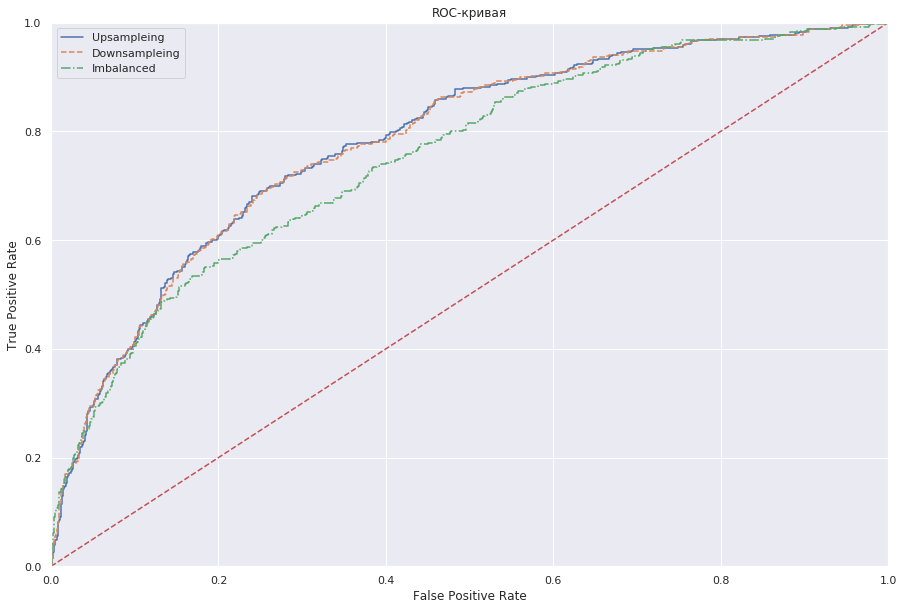

In [63]:
probabilities_valid_1 = logres_gs_ups.predict_proba(features_val) #вычисляем вероятности появления классов
probabilities_one_valid_1 = probabilities_valid_1[:, 1] #Значения вероятностей класса «1»
probabilities_valid_2 = logres_gs_downs.predict_proba(features_val) #вычисляем вероятности появления классов
probabilities_one_valid_2 = probabilities_valid_2[:, 1]
probabilities_valid_3 = logres_gs.predict_proba(features_val) #вычисляем вероятности появления классов
probabilities_one_valid_3 = probabilities_valid_3[:, 1]

#построим ROC-кривую
fpr_1, tpr_1, thresholds_1 = roc_curve(target_val, probabilities_one_valid_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(target_val, probabilities_one_valid_2)
fpr_3, tpr_3, thresholds_3 = roc_curve(target_val, probabilities_one_valid_3)

plt.figure(figsize=(15,10))
plt.plot(fpr_1, tpr_1, linestyle='-', label='Upsampleing')
plt.plot(fpr_2, tpr_2, linestyle='--', label='Downsampleing')
plt.plot(fpr_3, tpr_3, linestyle='-.', label='Imbalanсed')
#график для случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Увиденное наталкивает на мысль: если слегка увеличить полноту и снизить точность, то мера F1 должна остаться на месте. Попробуем перебрать пороговые значения, чтобы выбрать оптимальное.

Теперь выделим подходящие для нас значения F1 и найдём порог, при котором получили максимальную полноту.

In [76]:
from sklearn.metrics import f1_score
threshold_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
for threshold in np.arange(0, 1, 0.005):

    predicted_valid = probabilities_one_valid_2 > threshold
    precision = precision_score(target_val, predicted_valid)
    recall = recall_score(target_val, predicted_valid)
    f1 = f1_score(target_val, predicted_valid)
    roc_auc =  roc_auc_score(target_val, predicted_valid)
    
    threshold_list.append(threshold)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)

df = pd.DataFrame(
                 data = {'threshold': threshold_list,
                         'precision': precision_list,
                         'recall': recall_list,
                        'f1_score': f1_list,
                        'roc_auc': roc_auc_list})

print(df.loc[df['f1_score']>=0.59].sort_values(by='recall'))


Empty DataFrame
Columns: [threshold, precision, recall, f1_score, roc_auc]
Index: []


Перебор порогов вероятности не помог логистической регрессии поднять значение F1.

# Вывод

* Было обучено две модели случайного леса и логистическо регрессии.
* Из-за дисбаланса классов обе модели показали недостаточный уровень f1_score, необходимый для выполнения задачи.
* После взвешивания классов с помощью class_weight модель случайного леса все таки достигла необходимого уровня f1==0.61.
* А вот логистической регрессии взвешивание классов также помогло, однако значение f1 не достигнуло необходимого уровня (0,47).
* В качестве меры по увеличению знаячения f1 было прибегнуто к методам upsamling и downsampling. Необходимый уровень метрики качества был достигнут.


Однако в качестве итоговой модели для тестирования будем использовать модель дерева решений, так как она показывает лучшие результаты на валидационной выборке без применения искуственного изменения размеров выборок, а так же засчет запаса в значении f1, так как на тестовой выборке качество модели обычно ниже.

* В качестве гиперпарматеров будем использовать следующие значения: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 3, 'min_samples_split': 2}

# Тестирование модели

In [60]:
#тестируем модель на тестовой выборке, обучаем на обобщенной выборке(трайн+валид)

#features_test = features_test.loc[:, ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']] #для использования наиболее значимых параметров

features_train_valid = pd.concat([features_train, features_val])
target_train_valid = pd.concat([target_train, target_val])

model_train_valid = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth = 18, n_estimators = 30,
                                           criterion = 'entropy', min_samples_leaf=3, min_samples_split=2)
model_train_valid.fit(features_train_valid, target_train_valid)
#model_train_valid.fit(features_train, target_train)

prediction_test = model_train_valid.predict(features_test)
print('f1_score_test =', round(f1_score(target_test, prediction_test), 2))

f1_score_test = 0.62


In [61]:
print("Полнота случайного леса тестовой выборки:", round(recall_score(target_test, prediction_test), 2))
print("Точность случайного леса тестовой выборки:", round(precision_score(target_test, prediction_test), 2))

Полнота случайного леса тестовой выборки: 0.6
Точность случайного леса тестовой выборки: 0.64


In [62]:
print("Качество предсказаний случайного леса тестовой выборки:")
print()
print(classification_report(target_test, prediction_test))

Качество предсказаний случайного леса тестовой выборки:

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1593
           1       0.64      0.60      0.62       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.85      0.85      0.85      2000



*Проверим на адекватность выбранную модель, сраним accuracy эталонной модели с константной.*

In [52]:
model_constant = pd.Series(0, target_test)
print(accuracy_score(target_test, model_constant))

0.7965


Accuracy эталонной модели выше константной, что говорит об адекватности выбранной моделей.

# Общий вывод  

Нашей задачей было построить модель, которая предсказывала бы вероятный уход клиентов из банка, чтобы суметь их вовремя выявить и удержать.  
Мы изучили датасет и подготовили его к обучению:
* Избавились от лишних данных.
* Закодировали категориальные признаки по принципу One-Hot.
* Отмасштабировали количественные признаки, чтобы повысить точность логистической регрессии.
* Обучили модели случайного леса и логистической регрессии.
* Без учёта дисбалансов класса ни одна из моделей не показала достаточный результат.
* С учётом дисбаланса качество моделей улучшилось лишь у модели случайного леса.
* На валидационной выборке качество логистической регрессии подтянули методы upsampling и downsampling.
* Перебор порогов вероятности auc_roc модели логистической регрессии не помог поднять качетсво.
* Проверили случайный лес с оптимальными параметрами на тестовой выборке и получили F1, достаточное по условию проекта.
